In [1]:
# --- Bootstrap so we can import local modules from notebooks/ or project root ---
import sys
import matplotlib.pyplot as plt
from pathlib import Path

NB_DIR = Path.cwd()           # current working dir (likely .../notebooks)
PROJ_ROOT = NB_DIR.parent     # project root (one level up)

for p in (NB_DIR, PROJ_ROOT):
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))

# (Optional) auto-reload edited .py files without restarting the kernel
try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass

# --- Imports ---
import pandas as pd
from viz_results_toolkit import (
    load_results_dir,
    plot_violin, plot_box, plot_strip, plot_hist_overlaid,
    savefig_multi,
)

out_dir = PROJ_ROOT / "viz_out_results"
out_dir.mkdir(parents=True, exist_ok=True)

In [2]:
from pathlib import Path

results_root = Path("../results")

for workload_dir in sorted(results_root.iterdir()):
    if not workload_dir.is_dir():
        continue

    subdirs = sorted(
        (p for p in workload_dir.iterdir() if p.is_dir()),
        key=lambda p: p.name,
    )
    if not subdirs:
        continue

    print(f"{workload_dir.name}: {subdirs[-1].name}")


tpch_1_Q1: 20251104_111132
tpch_1_Q2: 20251104_111847
tpch_1_Q3: 20251104_112449
tpch_1_Q4: 20251104_113013
tpch_1_Q5: 20251104_113610
tpch_1_Q6: 20251104_114246
tpch_1_Q7: 20251104_114901
tpch_4_Q1: 20251104_162223
tpch_4_Q2: 20251104_163340
tpch_4_Q3: 20251104_164055
tpch_4_Q4: 20251104_164621
tpch_4_Q5: 20251104_165259
tpch_4_Q6: 20251104_170004
tpch_4_Q7: 20251104_170655


In [7]:
# --- Load each query result as its own DataFrame ---
q_sources = {
    "Q1": PROJ_ROOT / "results" / "tpch_1_Q1" / "20251104_111132",
    "Q2": PROJ_ROOT / "results" / "tpch_1_Q2" / "20251104_111847",
    "Q3": PROJ_ROOT / "results" / "tpch_1_Q3" / "20251104_112449",
    "Q4": PROJ_ROOT / "results" / "tpch_1_Q4" / "20251104_113013",
    "Q5": PROJ_ROOT / "results" / "tpch_1_Q5" / "20251104_113610",
    "Q6": PROJ_ROOT / "results" / "tpch_1_Q6" / "20251104_114246",
    "Q7": PROJ_ROOT / "results" / "tpch_1_Q7" / "20251104_114901",
}

dfs = {k: load_results_dir(v) for k, v in q_sources.items()}

# # --- Build a 1xN (or 2x2) grid of violins for the same metric across queries ---
# import math
# titles = list(dfs.keys())
# n = len(titles)
# ncols = 2 if n > 2 else n
# nrows = math.ceil(n / ncols)

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4*nrows), squeeze=False)

# metric = "bytesRead_ev"   # or "bytesRead_ev", "executorRunTime_s", etc.
# idx = 0
# for r in range(nrows):
#     for c in range(ncols):
#         ax = axes[r][c]
#         if idx < n:
#             q = titles[idx]
#             plot_box(dfs[q], metric=metric, group_cols=("engine", "layout"), title=q, ax=ax)
#         else:
#             ax.axis("off")  # hide extra cells if any
#         idx += 1

# fig.tight_layout()
# savefig_multi(fig, out_dir / f"violin_grid_{metric}")


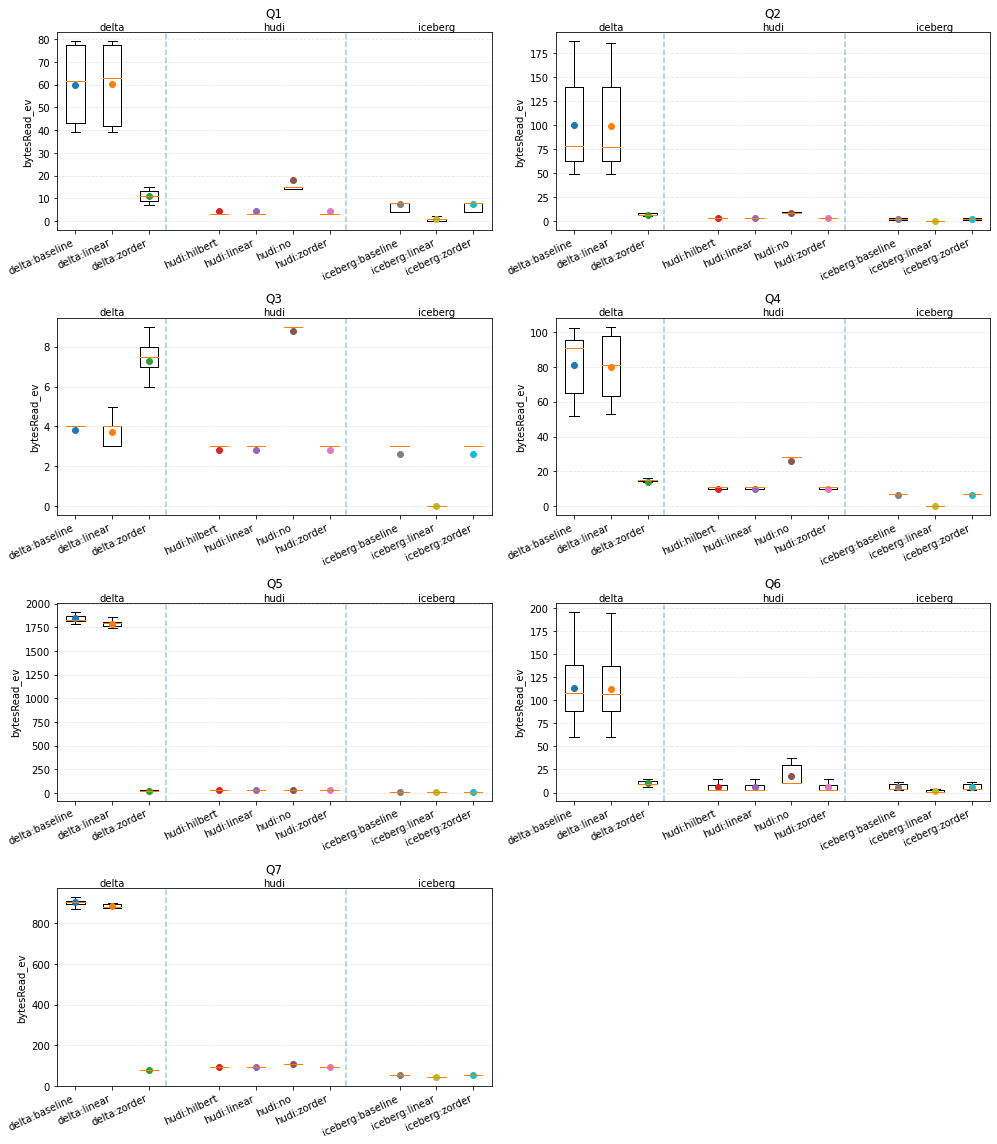

In [8]:
# --- Build a 1xN (or 2x2) grid; each subplot shows engine:layout groups,
#     partitioned into 3 blocks by engine with separators ---
import math

titles = list(dfs.keys())
n = len(titles)
ncols = 2 if n > 2 else n
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4*nrows), squeeze=False)

metric = "bytesRead_ev"
blocks_order = ("delta", "hudi", "iceberg")   # block order on the x-axis
BLOCK_GAP = 0.9                                # widen if you want thicker separation

for idx, q in enumerate(titles):
    r, c = divmod(idx, ncols)
    ax = axes[r][c]
    dfq = dfs[q]

    # 必须存在 engine / layout 两列
    assert "engine" in dfq.columns, f"[{q}] missing 'engine'"
    assert "layout" in dfq.columns, f"[{q}] missing 'layout'"

    # 这里用箱线图；想要小提琴就把 plot_box 换成 plot_violin，其他参数不变
    plot_box(
        dfq, metric=metric,
        group_cols=("engine", "layout"),   # x 轴为 engine:layout
        title=q, ax=ax,
        block_col="engine",                # 分区按 engine（delta/hudi/iceberg）
        blocks_order=blocks_order,
        block_gap=BLOCK_GAP,               # 控制分区之间的留白
    )

# 关掉空白子图
for k in range(n, nrows * ncols):
    r, c = divmod(k, ncols)
    axes[r][c].axis("off")

fig.tight_layout()
savefig_multi(fig, out_dir / f"grid_{metric}_engine_layout_with_separators")

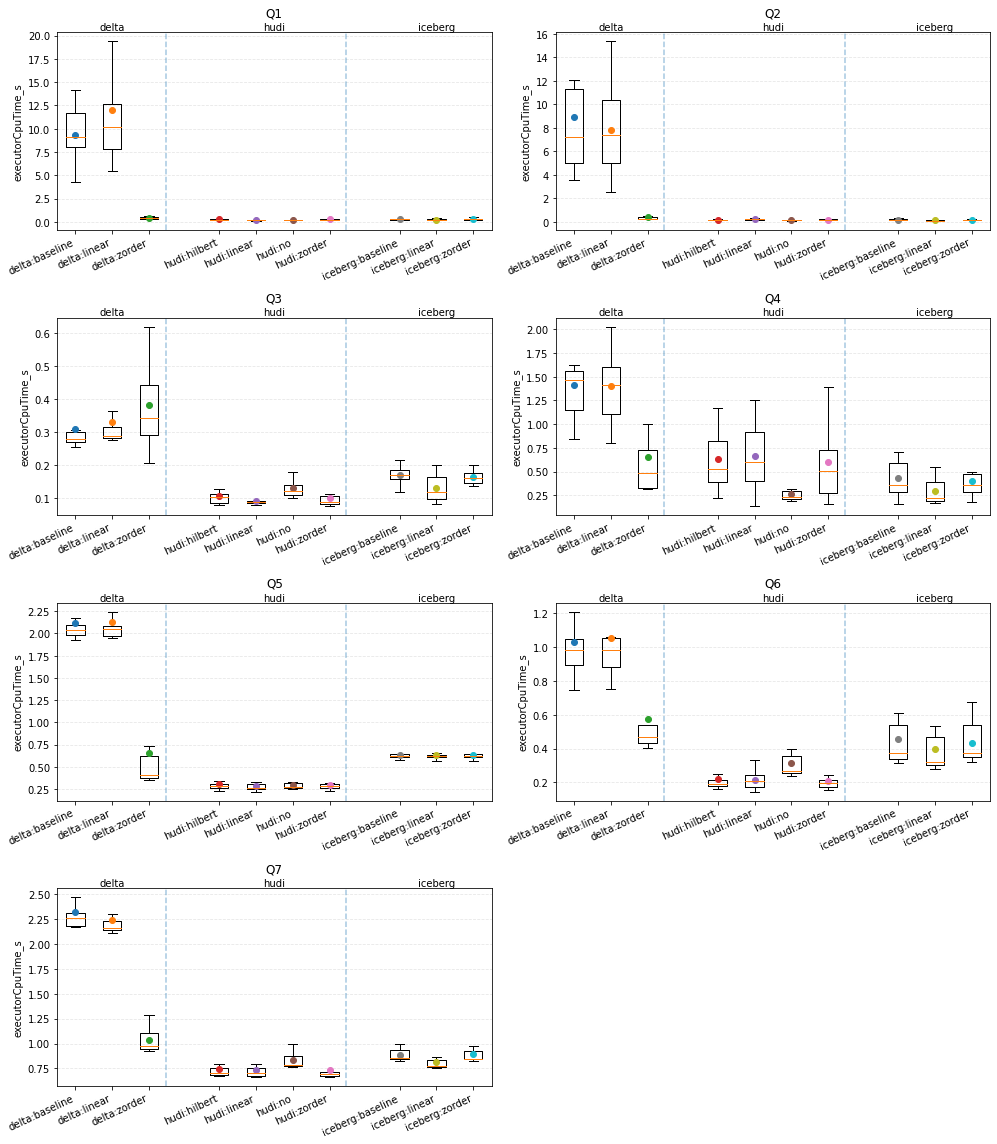

In [10]:
import math

titles = list(dfs.keys())
n = len(titles)
ncols = 2 if n > 2 else n
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4*nrows), squeeze=False)

metric = "executorCpuTime_s"
blocks_order = ("delta", "hudi", "iceberg")   # block order on the x-axis
BLOCK_GAP = 0.9                                # widen if you want thicker separation

for idx, q in enumerate(titles):
    r, c = divmod(idx, ncols)
    ax = axes[r][c]
    dfq = dfs[q]

    # 必须存在 engine / layout 两列
    assert "engine" in dfq.columns, f"[{q}] missing 'engine'"
    assert "layout" in dfq.columns, f"[{q}] missing 'layout'"

    # 这里用箱线图；想要小提琴就把 plot_box 换成 plot_violin，其他参数不变
    plot_box(
        dfq, metric=metric,
        group_cols=("engine", "layout"),   # x 轴为 engine:layout
        title=q, ax=ax,
        block_col="engine",                # 分区按 engine（delta/hudi/iceberg）
        blocks_order=blocks_order,
        block_gap=BLOCK_GAP,               # 控制分区之间的留白
    )

# 关掉空白子图
for k in range(n, nrows * ncols):
    r, c = divmod(k, ncols)
    axes[r][c].axis("off")

fig.tight_layout()
savefig_multi(fig, out_dir / f"grid_{metric}_engine_layout_with_separators")

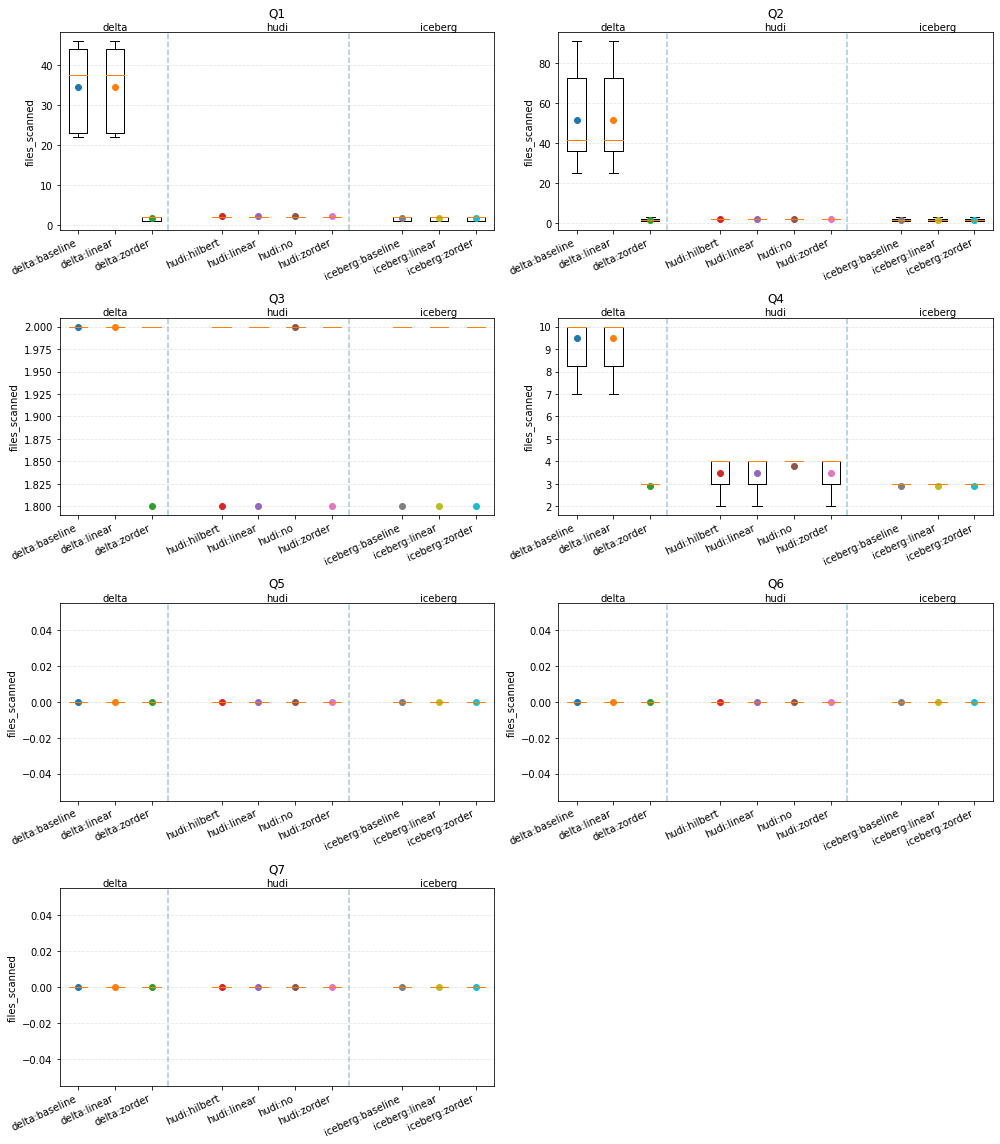

In [11]:
import math

titles = list(dfs.keys())
n = len(titles)
ncols = 2 if n > 2 else n
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4*nrows), squeeze=False)

metric = "files_scanned"
blocks_order = ("delta", "hudi", "iceberg")   # block order on the x-axis
BLOCK_GAP = 0.9                                # widen if you want thicker separation

for idx, q in enumerate(titles):
    r, c = divmod(idx, ncols)
    ax = axes[r][c]
    dfq = dfs[q]

    # 必须存在 engine / layout 两列
    assert "engine" in dfq.columns, f"[{q}] missing 'engine'"
    assert "layout" in dfq.columns, f"[{q}] missing 'layout'"

    # 这里用箱线图；想要小提琴就把 plot_box 换成 plot_violin，其他参数不变
    plot_box(
        dfq, metric=metric,
        group_cols=("engine", "layout"),   # x 轴为 engine:layout
        title=q, ax=ax,
        block_col="engine",                # 分区按 engine（delta/hudi/iceberg）
        blocks_order=blocks_order,
        block_gap=BLOCK_GAP,               # 控制分区之间的留白
    )

# 关掉空白子图
for k in range(n, nrows * ncols):
    r, c = divmod(k, ncols)
    axes[r][c].axis("off")

fig.tight_layout()
savefig_multi(fig, out_dir / f"grid_{metric}_engine_layout_with_separators")